<a href="https://colab.research.google.com/github/RendiZein/Horse-vs-Human-Classification/blob/main/Horses_vs_Humans_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Horses vs Humans with Transfer Learning



In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Dataset

Use the `Horse or Human dataset`, which contains images of horses and humans.

In [ ]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = '/content/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

This dataset already has an structure that is compatible with Keras' `flow_from_directory`

In [ ]:
# Define the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



take a look at a sample image of each one of the classes:

Sample horse image:


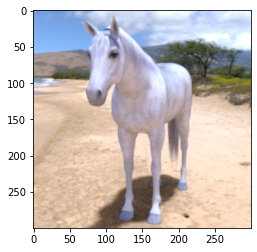


Sample human image:


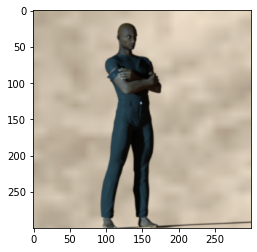

In [ ]:
print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[5])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[5])}"))
plt.show()

Check that these images have a resolution of 300x300 and are colored

In [ ]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


The sample image has a resolution of 300x300 and the last dimension is used for each one of the RGB channels to represent color.

## Training and Validation Generators

After dealing with the images, code the generators that will fed these images into the Network and modify the resolution to make it compatible with `flow_from_directory`. So it will be lower the number of trainable parameters in the final network, yielding much quicker training times without compromising the accuracy

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class 
  # Normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
  
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-03-31 08:55:44--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   262MB/s    in 0.3s    

2022-03-31 08:55:44 (262 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Load the `InceptionV3` model and save the path to the weights that just downloaded:

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False #Avoid train the layer

  return pre_trained_model
  

Check that everything went well by comparing the last few rows of the model summary to the expected output:

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_658 (Conv2D)            (None, 74, 74, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_658 (Batch  (None, 74, 74, 32)  96          ['conv2d_658[0][0]']             
 Normalization)                                                                                   
                                                                                       

Check that all the layers in the model were set to be non-trainable.

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


## Creating callbacks for later

Set argument so the callback to stop training once an accuracy of 99.9% is reached

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

## Pipelining the pre-trained model with your own

Now that the pre-trained model is ready, "glue" it to new model to solve the task at hand. So the last output of the pre-trained model will be the input for new model.


In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  return last_output

Check that everything works as expected:

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


Create the final model by adding some additional layers on top of the pre-trained model use Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional). But, check it again 

In [ ]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


Create the final model with Keras' Model class

In [ ]:
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)   
  # Add a final sigmoid layer for classification
  x = layers.Dense  (1, activation='sigmoid')(x)      

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['acc'])
  
  return model


In [ ]:
# Save new model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")
# model.summary()

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [ ]:
# fires, and stops training at 99.9% accuracy
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
33/33 - 19s - loss: 0.1461 - acc: 0.9318 - val_loss: 0.0053 - val_acc: 1.0000 - 19s/epoch - 574ms/step
Epoch 2/100
33/33 - 13s - loss: 0.0251 - acc: 0.9922 - val_loss: 0.0351 - val_acc: 0.9883 - 13s/epoch - 406ms/step
Epoch 3/100
33/33 - 13s - loss: 0.0323 - acc: 0.9912 - val_loss: 0.1149 - val_acc: 0.9727 - 13s/epoch - 404ms/step
Epoch 4/100
33/33 - 13s - loss: 0.0116 - acc: 0.9942 - val_loss: 0.0063 - val_acc: 0.9961 - 13s/epoch - 406ms/step
Epoch 5/100
33/33 - 13s - loss: 0.0130 - acc: 0.9942 - val_loss: 0.0232 - val_acc: 0.9922 - 13s/epoch - 408ms/step
Epoch 6/100
33/33 - 14s - loss: 0.0056 - acc: 0.9981 - val_loss: 8.1610e-04 - val_acc: 1.0000 - 14s/epoch - 409ms/step
Epoch 7/100
33/33 - 13s - loss: 0.0333 - acc: 0.9922 - val_loss: 0.0462 - val_acc: 0.9883 - 13s/epoch - 409ms/step
Epoch 8/100
33/33 - 13s - loss: 0.0185 - acc: 0.9932 - val_loss: 0.0402 - val_acc: 0.9883 - 13s/epoch - 408ms/step
Epoch 9/100
33/33 - 13s - loss: 0.0075 - acc: 0.9971 - val_loss: 0.0155 - va

In [ ]:
print(history.history)

{'loss': [0.14605902135372162, 0.025098541751503944, 0.03232305496931076, 0.011591496877372265, 0.012980041094124317, 0.005638446658849716, 0.03334455564618111, 0.01845920830965042, 0.0074770585633814335, 0.004899226129055023, 0.01063612662255764, 0.010087462142109871, 0.00871119275689125, 0.002780881943181157], 'acc': [0.9318403005599976, 0.992210328578949, 0.9912366271018982, 0.9941577315330505, 0.9941577315330505, 0.9980525970458984, 0.992210328578949, 0.9931840300559998, 0.9970788955688477, 0.9980525970458984, 0.9970788955688477, 0.9961051344871521, 0.9970788955688477, 0.9990262985229492], 'val_loss': [0.005295955576002598, 0.03510914370417595, 0.11485803127288818, 0.006259659770876169, 0.023160109296441078, 0.0008161001023836434, 0.046208351850509644, 0.040237993001937866, 0.015503808856010437, 0.1229577362537384, 0.06515239179134369, 0.013723303563892841, 0.17098823189735413, 0.006555391941219568], 'val_acc': [1.0, 0.98828125, 0.97265625, 0.99609375, 0.9921875, 1.0, 0.98828125, 0

Now take a quick look at the training and validation accuracies for each epoch of training:

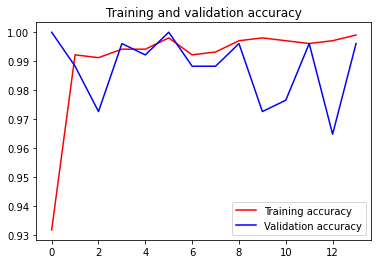

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()